© 2024 Nokia
Licensed under the BSD 3 Clause Clear License  
SPDX-License-Identifier: BSD-3-Clause-Clear

In [1]:
import os
import pickle
import re

import pandas as pd
import scipy
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from fairness_utilities import *
# from definitions import ROOT_DIR

from sklearn import metrics

import seaborn as sns
sns.set(font_scale = 1.5)

seed = 2
tf.random.set_seed(seed)
np.random.seed(seed)

import simclr_models
import simclr_utitlities

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

sns.set(style='white', context="poster", font='Work Sans Regural')

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


## MODEL SUMMARY

In [2]:
# December 2023 Models -> MESA
# SUPERVISED
# subfolder = '20231204-074617_l2_e200_esTrue_bs64_wTrue'
# model_name = 'supervised.finetuned.0.59.hdf5'
# frozen_layers = ''
# added_layers = 2
# tag = 'supervised'
# FROZEN: 0
# subfolder = '20231201-090723_e200_esTrue_bs128_wTrue_f0'
# model_name = 'simclr.frozen.6.26.hdf5'
# frozen_layers = 0
# added_layers = 2
# tag = 'frozen0'
# # FROZEN: 1
# subfolder = '20231201-091643_e200_esTrue_bs128_wTrue_f1'
# model_name = 'simclr.frozen.9.05.hdf5'
# frozen_layers = 1
# added_layers = 2
# tag = 'frozen1'
# # FROZEN: 1 (m)
# subfolder = '20231201-085552_e200_esTrue_bs128_wTrue_f1_m'
# model_name = 'simclr.frozen.16.93.hdf5'
# frozen_layers = 1
# added_layers = 2
# tag = 'frozen1m'
# # FROZEN: 2
# subfolder = '20231201-092528_e200_esTrue_bs128_wTrue_f2'
# model_name = 'simclr.frozen.11.65.hdf5'
# frozen_layers = 2
# added_layers = 2
# tag = 'frozen2'
# FROZEN: 2 (f-l)
subfolder = '20231201-084504_e200_esTrue_bs128_wTrue_f2_fl'
model_name = 'simclr.frozen.16.12.hdf5'
frozen_layers = 2
added_layers = 2
tag = 'frozen2fl'
# # FROZEN: 3
# subfolder = '20231201-093337_e200_esTrue_bs128_wTrue_f3'
# model_name = 'simclr.frozen.25.36.hdf5'
# frozen_layers = 3
# added_layers = 2
# tag = 'frozen3'

In [3]:
# Dataset-specific
# working_directory = 'SleepEEG/'
# data_folder = 'SleepEEG'
# data folder structure
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
data_folder = 'MESA'
# model folder structure
working_directory = 'MESA/'

# SimCLR finetuned model
# DETAILS TO EDIT FOR RUN START HERE
# SUPERVISED
# subfolder = '20230405-132618_l2_e100_esFalse_bs128_wTrue'
# model_name = 'supervised.finetuned.0.90.hdf5'
# frozen_layers = ''
# added_layers = 2
# tag = 'supervised'
# FROZEN: 0
# subfolder = '20230405-191053_e100_esFalse_bs128_wTrue_f0'
# model_name = 'simclr.frozen.0.91.hdf5'
# frozen_layers = 0
# added_layers = 2
# tag = 'frozen0'
# # FROZEN: 1
# subfolder = '20230405-205951_e100_esFalse_bs128_wTrue_f1'
# model_name = 'simclr.frozen.0.90.hdf5'
# frozen_layers = 1
# added_layers = 2
# tag = 'frozen1'
# # FROZEN: 1 (m)
# subfolder = '20230405-172612_e100_esFalse_bs128_wTrue_f1_m'
# model_name = 'simclr.frozen.0.90.hdf5'
# frozen_layers = 1
# added_layers = 2
# tag = 'frozen1m'
# # FROZEN: 2
# subfolder = '20230405-224147_e100_esFalse_bs128_wTrue_f2'
# model_name = 'simclr.frozen.0.86.hdf5'
# frozen_layers = 2
# added_layers = 2
# tag = 'frozen2'
# FROZEN: 2 (f-l)
# subfolder = '20230405-154639_e100_esFalse_bs128_wTrue_f2_fl'
# model_name = 'simclr.frozen.0.89.hdf5'
# frozen_layers = 2
# added_layers = 2
# tag = 'frozen2fl'
# # FROZEN: 3
# subfolder = '20230406-001353_e100_esFalse_bs128_wTrue_f3'
# model_name = 'simclr.frozen.0.86.hdf5'
# frozen_layers = 3
# added_layers = 2
# tag = 'frozen3'

# DETAILS TO EDIT FOR RUN END HERE
# Select appropriate paths depending on model type
# SimCLR models
if tag=="supervised":
    pretrained_model = tf.keras.models.load_model(os.path.join("../Supervised", working_directory, subfolder, model_name), compile=False)  # compile=False as we use the model only for inference
    image_folder = os.path.join("../Supervised", data_folder, 'img', subfolder)
else:
    pretrained_model = tf.keras.models.load_model(os.path.join(working_directory, subfolder, model_name), compile=False)  # compile=False as we use the model only for inference
    image_folder = os.path.join(data_folder, 'img', subfolder)

# supervised models
# pretrained_model = tf.keras.models.load_model(os.path.join("../Supervised", working_directory, subfolder, model_name), compile=False)  # compile=False as we use the model only for inference
# image_folder = os.path.join("../Supervised", data_folder, 'img', subfolder)

# create image folder
if not os.path.exists(image_folder):
    os.makedirs(image_folder)
pretrained_model.summary()

Model: "TPN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 101, 5)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 78, 32)            3872      
_________________________________________________________________
dropout (Dropout)            (None, 78, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 63, 64)            32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 56, 96)            49248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 96)            0       

## DATA SHAPES

In [4]:
# Load preprocessed data
np_train = (np.load(os.path.join(data_folder, 'train_x.npy')),
           np.load(os.path.join(data_folder, 'train_y.npy')))
np_val = (np.load(os.path.join(data_folder, 'val_x.npy')),
           np.load(os.path.join(data_folder, 'val_y.npy')))
np_test = (np.load(os.path.join(data_folder, 'test_x.npy')),
           np.load(os.path.join(data_folder, 'test_y.npy')))

probs = pretrained_model.predict(np_test[0])
predictions = np.argmax(probs, axis=1)
# print(simclr_utitlities.evaluate_model_simple(pretrained_model.predict(np_test[0]), np_test[1], return_dict=True))

In [5]:
print("Train - Validation - Test Set Shapes:")
print("Train X: {} - Val X: {} - Test X: {}".format(np_train[0].shape, np_val[0].shape, np_test[0].shape))
print("Train y: {} - Val y: {} - Test y: {}".format(np_train[1].shape, np_val[1].shape, np_test[1].shape))

Train - Validation - Test Set Shapes:
Train X: (1449147, 101, 5) - Val X: (365497, 101, 5) - Test X: (452015, 101, 5)
Train y: (1449147, 2) - Val y: (365497, 2) - Test y: (452015, 2)


In [6]:
# The test set values agree with the ones reported in the original paper: https://arxiv.org/pdf/1703.07771.pdf
pd.Series(np_test[1][:,1]).value_counts()

1.0    262499
0.0    189516
dtype: int64

In [8]:
# for server
ROOT_DIR = "../../../"
os.chdir(ROOT_DIR)
subjects = pd.read_csv(os.path.join('datasets', data_folder, 'demographics.csv'), delimiter=';')
# subject IDs per train-validation-test set
train_listfile = pd.read_csv(os.path.join('datasets', data_folder, 'train_listfile.csv'))
val_listfile = pd.read_csv(os.path.join('datasets', data_folder, 'val_listfile.csv'))
test_listfile = pd.read_csv(os.path.join('datasets', data_folder, 'test_listfile.csv'))
# change back the working directory
os.chdir(os.path.join('code', 'baselines', 'SimCLR'))
subjects.head()

,mesaid,examnumber,nsrr_age,nsrr_age_gt89,nsrr_sex,nsrr_race,nsrr_ahi_hp3u,nsrr_ahi_hp3r_aasm15,nsrr_ahi_hp4u_aasm15,nsrr_ahi_hp4r,nsrr_ttldursp_f1,nsrr_phrnumar_f1,nsrr_flag_spsw
0,1,5,70.0,no,female,white,18.14,27.56,9.94,23.02,344.0,27.03,full scoring
1,2,5,83.0,no,female,white,8.34,10.75,3.85,7.38,374.0,24.55,full scoring
2,6,5,57.0,no,female,hispanic,62.51,67.21,51.12,58.32,358.0,21.79,full scoring
3,10,5,57.0,no,male,white,40.91,48.00,32.18,45.27,110.0,46.91,full scoring
4,12,5,80.0,no,male,white,27.47,33.63,20.22,29.89,273.0,28.79,full scoring


## PROTECTED ATTRIBUTE DISTRIBUTIONS

In [9]:
df = pd.concat([train_listfile, val_listfile, test_listfile])
print("Total rows: {}".format(df.shape[0]))
print(df.head(100))

Total rows: 2266659
    mesaid  wake
0     1010   0.0
1     1010   0.0
2     1010   0.0
3     1010   0.0
4     1010   0.0
..     ...   ...
95    1010   0.0
96    1010   0.0
97    1010   0.0
98    1010   0.0
99    1010   1.0

[100 rows x 2 columns]


In [10]:
len(pd.unique(df.mesaid))

1817

In [11]:
# join with demographics
print("Total rows before merging: {}".format(df.shape[0]))
df = df.merge(subjects, how='left', on='mesaid')
print("Total rows after merging: {}".format(df.shape[0]))

Total rows before merging: 2266659
Total rows after merging: 2266659


In [12]:
# Calculate frequences
df.loc[:, 'nsrr_age_gt65'] = df.nsrr_age.map(lambda age: 'no' if age < 65 else 'yes')
df.loc[:, 'AGE'] = df.nsrr_age.map(lambda age: '<65' if age < 65 else '>=65')

df.head()

,mesaid,wake,examnumber,nsrr_age,nsrr_age_gt89,nsrr_sex,nsrr_race,nsrr_ahi_hp3u,nsrr_ahi_hp3r_aasm15,nsrr_ahi_hp4u_aasm15,nsrr_ahi_hp4r,nsrr_ttldursp_f1,nsrr_phrnumar_f1,nsrr_flag_spsw,nsrr_age_gt65,AGE
0,1010,0.0,5,82.0,no,female,black or african american,18.29,21.8,12.29,16.68,410.0,22.1,full scoring,yes,>=65
1,1010,0.0,5,82.0,no,female,black or african american,18.29,21.8,12.29,16.68,410.0,22.1,full scoring,yes,>=65
2,1010,0.0,5,82.0,no,female,black or african american,18.29,21.8,12.29,16.68,410.0,22.1,full scoring,yes,>=65
3,1010,0.0,5,82.0,no,female,black or african american,18.29,21.8,12.29,16.68,410.0,22.1,full scoring,yes,>=65
4,1010,0.0,5,82.0,no,female,black or african american,18.29,21.8,12.29,16.68,410.0,22.1,full scoring,yes,>=65


In [13]:
protected_attributes = ['nsrr_age_gt89', 'nsrr_age_gt65', 'AGE', 'nsrr_sex', 'nsrr_race']
privileged_classes = [['no'], ['no'], ['<65'], ['male'], ['white']]

count_df = pd.concat(axis=0, ignore_index=True, objs=[
    df[protected_attribute].value_counts().reset_index(drop=False) for protected_attribute in protected_attributes
])
count_df = count_df.melt('index')
count_df.dropna(axis=0, inplace=True)
count_df.reset_index(inplace=True, drop=True)
# count_df["majority"] = np.where(count_df.index % 2, 0, 1)
# count_df.loc[:, "label"] = count_df.apply(lambda row: FRIENDLY_LABELS.get(row['variable']).get(row['index']), axis=1)
count_df.head(20)

,index,variable,value
0,no,nsrr_age_gt89,2244116.0
1,yes,nsrr_age_gt89,22543.0
2,yes,nsrr_age_gt65,1428614.0
3,no,nsrr_age_gt65,838045.0
4,>=65,AGE,1428614.0
5,<65,AGE,838045.0
6,female,nsrr_sex,1237012.0
7,male,nsrr_sex,1029647.0
8,white,nsrr_race,850678.0
9,black or african american,nsrr_race,637267.0


In [14]:
count_df.loc[:, 'label'] = count_df["index"].apply(lambda v: 'Black' if v=='black or african american' else ('F' if v=='female' else ('M' if v=='male' else str.capitalize(v))))
count_df.loc[:, 'x_label'] = count_df["variable"].apply(lambda v: 'SEX' if v=='nsrr_sex' else ('RACE' if v=='nsrr_race' else v))
count_df

,index,variable,value,label,x_label
0,no,nsrr_age_gt89,2244116.0,No,nsrr_age_gt89
1,yes,nsrr_age_gt89,22543.0,Yes,nsrr_age_gt89
2,yes,nsrr_age_gt65,1428614.0,Yes,nsrr_age_gt65
3,no,nsrr_age_gt65,838045.0,No,nsrr_age_gt65
4,>=65,AGE,1428614.0,>=65,AGE
5,<65,AGE,838045.0,<65,AGE
6,female,nsrr_sex,1237012.0,F,SEX
7,male,nsrr_sex,1029647.0,M,SEX
8,white,nsrr_race,850678.0,White,RACE
9,black or african american,nsrr_race,637267.0,Black,RACE


In [15]:
count_df.loc[:, "Segment"] = count_df["index"].apply(lambda i: "Majority" if (i=="female" or i=="white" or i==">=65") else "Minority")
count_df

,index,variable,value,label,x_label,Segment
0,no,nsrr_age_gt89,2244116.0,No,nsrr_age_gt89,Minority
1,yes,nsrr_age_gt89,22543.0,Yes,nsrr_age_gt89,Minority
2,yes,nsrr_age_gt65,1428614.0,Yes,nsrr_age_gt65,Minority
3,no,nsrr_age_gt65,838045.0,No,nsrr_age_gt65,Minority
4,>=65,AGE,1428614.0,>=65,AGE,Majority
5,<65,AGE,838045.0,<65,AGE,Minority
6,female,nsrr_sex,1237012.0,F,SEX,Majority
7,male,nsrr_sex,1029647.0,M,SEX,Minority
8,white,nsrr_race,850678.0,White,RACE,Majority
9,black or african american,nsrr_race,637267.0,Black,RACE,Minority


In [16]:
# sns.set_style('whitegrid')
# sns.set(font_scale = 1.5)
count_df = count_df[count_df.variable.isin(['AGE', 'nsrr_sex', 'nsrr_race'])]
# g = sns.catplot(data=count_df[count_df.index.notnull()], x="label", col="x_label", y="value", kind='bar', hue="Segment", palette=['#1c9e77', '#cccccc'], sharex=False, ci=None, aspect=.5)
# ratios = count_df.groupby('x_label')['label'].nunique().values
ratios = [2, 2, 4]
count_df.loc[:, "x_label"] = count_df.loc[:, "x_label"].apply(lambda l: 'GENDER' if l=='SEX' else ('ETHNICITY' if l=='RACE' else l))

C:\Users\syfan\PycharmProjects\TFC-pretraining\venv\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


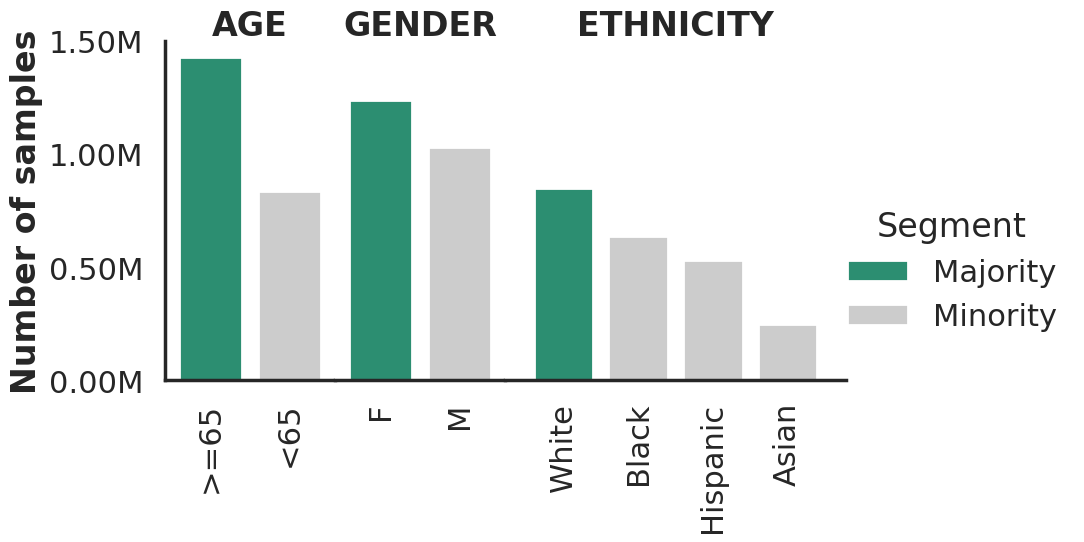

In [17]:
sns.set(style='white', context="poster", font='Work Sans Regural')

g = sns.catplot(data=count_df[count_df.index.notnull()], x="label", col="x_label", ci=None, y="value", kind='bar', sharex=False, aspect=.5, dodge=False, hue="Segment", palette=['#1c9e77', '#cccccc'], facet_kws={'gridspec_kws':{'width_ratios': ratios}})

g.set_titles("{col_name}")
g.set_ylabels('Number of samples')
g.set_xlabels('Protected Attribute')
g.set_xticklabels(rotation=90)

# plt.suptitle("Privileged vs. Unprivileged Group Representation (#Samples)")
for ax in g.axes.flat[1:]:
    sns.despine(ax=ax, left=True)
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_title(), fontdict={'weight': 'bold'})
    ax.set_title('')
    ax.margins(x=0.1) # slightly more margin as a separation
    ax.xaxis.set_label_position('top')
    ylabels = ['{:,.2f}'.format(x) + 'M' for x in ax.get_yticks()/1000000]
    ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
    ax.set_yticklabels(ylabels)
plt.subplots_adjust(wspace=0, bottom=0.18, left=0.06)

# plt.legend(labels=['Majority Segment', 'Minority Segment'], labelcolor=['#1c9e77', '#e72a8a'])
# plt.show()

plt.savefig(os.path.join(image_folder, 'representationBar.pdf'), format='pdf', bbox_inches="tight")
plt.savefig(os.path.join(image_folder, 'representationBar.png'))

In [18]:
image_folder

'MESA\\img\\20231201-084504_e200_esTrue_bs128_wTrue_f2_fl'

In [19]:
# get numbers
# count_df_merged.groupby('variable').
count_df['percentage'] = count_df['value'] / count_df.groupby('variable')['value'].transform('sum')
count_df

C:\Users\syfan\AppData\Local\Temp\ipykernel_26456\3767609374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_df['percentage'] = count_df['value'] / count_df.groupby('variable')['value'].transform('sum')


,index,variable,value,label,x_label,Segment,percentage
4,>=65,AGE,1428614.0,>=65,AGE,Majority,0.630273
5,<65,AGE,838045.0,<65,AGE,Minority,0.369727
6,female,nsrr_sex,1237012.0,F,GENDER,Majority,0.545742
7,male,nsrr_sex,1029647.0,M,GENDER,Minority,0.454258
8,white,nsrr_race,850678.0,White,ETHNICITY,Majority,0.375300
9,black or african american,nsrr_race,637267.0,Black,ETHNICITY,Minority,0.281148
10,hispanic,nsrr_race,530641.0,Hispanic,ETHNICITY,Minority,0.234107
11,asian,nsrr_race,248073.0,Asian,ETHNICITY,Minority,0.109444


## OVERALL PERFORMANCE

In [245]:
# Overall performance
print("\n--- Train Performance Overall ---")
train_predictions = pretrained_model.predict(np_train[0])
train_performance = simclr_utitlities.evaluate_model_simple(train_predictions, np_train[1], return_dict=True, only_auc=True)
print(train_performance)
print("\n--- Validation Performance Overall ---")
validation_predictions = pretrained_model.predict(np_val[0])
validation_performance = simclr_utitlities.evaluate_model_simple(validation_predictions, np_val[1], return_dict=True, only_auc=True)
print(validation_performance)
print("\n--- Test Performance Overall ---")
test_predictions = pretrained_model.predict(np_test[0])
test_performance = simclr_utitlities.evaluate_model_simple(test_predictions, np_test[1], return_dict=True, only_auc=True)
# remove metrics for speed
print(test_performance)


--- Train Performance Overall ---
{'Confusion Matrix': array([[459577, 152397],
       [236699, 600474]], dtype=int64), 'AUROC': 0.7915007276912199}

--- Validation Performance Overall ---
{'Confusion Matrix': array([[120598,  36884],
       [ 63557, 144458]], dtype=int64), 'AUROC': 0.7937781057470445}

--- Test Performance Overall ---
{'Confusion Matrix': array([[142130,  47386],
       [ 71431, 191068]], dtype=int64), 'AUROC': 0.7965091772672692}


In [246]:
test_performance

{'Confusion Matrix': array([[142130,  47386],
        [ 71431, 191068]], dtype=int64),
 'AUROC': 0.7965091772672692}

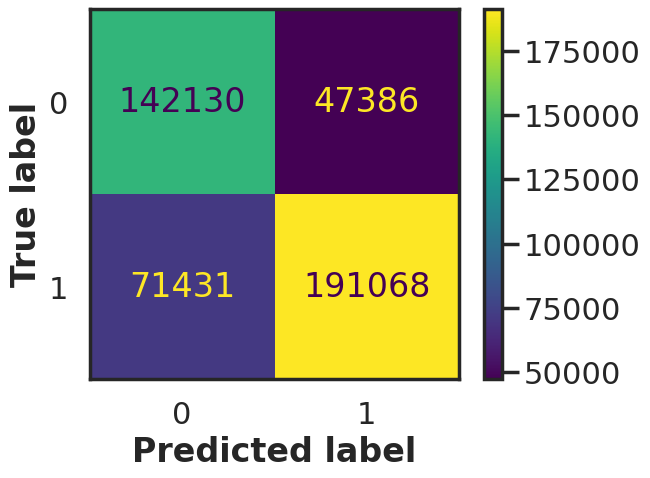

In [247]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = test_performance.get("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
disp.figure_.savefig(os.path.join(image_folder, 'confusion_matrix.pdf'))

In [248]:
# overall
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1], test_predictions, metric='AUROC')
print("Test Set AUC-ROC:\nAUC={} [CI {}-{}]".format(
    test_performance.get("AUROC"),
    low_CI_binary,
    high_CI_binary
))
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1], test_predictions, metric='AUPRC Micro')
print("Test Set AUC-PRC:\nAUC-PRC={} [CI {}-{}]".format(
    test_performance.get("AUPRC"),
    low_CI_binary,
    high_CI_binary
))

Test Set AUC-ROC:
AUC=0.7965091772672692 [CI 0.7951304067553411-0.7979461759295585]
Test Set AUC-PRC:
AUC-PRC=None [CI 0.7665827302964178-0.7706944291407972]


In [249]:
import tensorflow.keras.backend as K

trainable_count = np.sum([K.count_params(w) for w in pretrained_model.trainable_weights])
metrics_ci = []
averages_ci = []
lows_ci = []
highs_ci = []
for metric in test_performance:
    if (metric == "Confusion Matrix") or (metric == "Kappa"):
        continue
    print("Calculating CI for {}...".format(metric))
    low_CI_binary, high_CI_binary = get_ci_auc(np_test[1], test_predictions, metric=metric)
    metrics_ci.append(metric)
    averages_ci.append(test_performance.get(metric))
    highs_ci.append(high_CI_binary)
    lows_ci.append(low_CI_binary)
print(metrics_ci)
all_metrics_ci = pd.DataFrame({'metric': metrics_ci, 'value': averages_ci, 'low_ci': lows_ci, 'high_ci': highs_ci, 'parameters': trainable_count, 'model_name': model_name, 'subfolder': subfolder, 'added_layers': added_layers, 'frozen_layers': frozen_layers, 'tag': tag})

Calculating CI for AUROC...
['AUROC']


In [250]:
working_directory = os.path.join("../SimCLR", 'MESA')
all_metrics_ci.to_csv(os.path.join(working_directory, subfolder, model_name.replace('.hdf5', '_ci_metrics.csv')), index=False)
all_metrics_ci.head(10)

,metric,value,low_ci,high_ci,parameters,model_name,subfolder,added_layers,frozen_layers,tag
0,AUROC,0.796509,0.795054,0.797957,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl


In [251]:
# logging results
# results = pd.DataFrame(columns=['model', 'aucroc', 'gender_best', 'gender_best_auc', 'gender_best_delta', 'gender_worst', 'gender_worst_auc', 'gender_worst_delta'])
results = {'model': subfolder, 'auc': test_performance.get('AUROC'), 'protected_attributes': {}}

## BIAS ANALYSIS

In [252]:
sns.set(style='white', font='Work Sans Regural')

In [253]:
test_listfile.head(20)

,mesaid,wake
0,1080,0.0
1,1080,0.0
2,1080,1.0
3,1080,0.0
4,1080,0.0
5,1080,0.0
6,1080,0.0
7,1080,0.0
8,1080,0.0
9,1080,0.0


In [254]:
# merge demographics in test df
test_listfile = test_listfile.merge(subjects, on="mesaid", how="left")
test_listfile.head()

,mesaid,wake,examnumber,nsrr_age,nsrr_age_gt89,nsrr_sex,nsrr_race,nsrr_ahi_hp3u,nsrr_ahi_hp3r_aasm15,nsrr_ahi_hp4u_aasm15,nsrr_ahi_hp4r,nsrr_ttldursp_f1,nsrr_phrnumar_f1,nsrr_flag_spsw
0,1080,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring
1,1080,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring
2,1080,1.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring
3,1080,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring
4,1080,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring


In [255]:
test_listfile.loc[:, 'nsrr_age_gt65'] = test_listfile.nsrr_age.map(lambda age: 'no' if age < 65 else 'yes')
test_listfile.head()

,mesaid,wake,examnumber,nsrr_age,nsrr_age_gt89,nsrr_sex,nsrr_race,nsrr_ahi_hp3u,nsrr_ahi_hp3r_aasm15,nsrr_ahi_hp4u_aasm15,nsrr_ahi_hp4r,nsrr_ttldursp_f1,nsrr_phrnumar_f1,nsrr_flag_spsw,nsrr_age_gt65
0,1080,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring,yes
1,1080,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring,yes
2,1080,1.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring,yes
3,1080,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring,yes
4,1080,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring,yes


In [256]:
print("Test rows with null demograpphics: {} ({}%)".format(test_listfile.mesaid.isna().sum(), test_listfile.mesaid.isna().sum()/test_listfile.shape[0]))
test_listfile.drop(columns=['mesaid'], inplace=True)
test_listfile.head()

Test rows with null demograpphics: 0 (0.0%)


,wake,examnumber,nsrr_age,nsrr_age_gt89,nsrr_sex,nsrr_race,nsrr_ahi_hp3u,nsrr_ahi_hp3r_aasm15,nsrr_ahi_hp4u_aasm15,nsrr_ahi_hp4r,nsrr_ttldursp_f1,nsrr_phrnumar_f1,nsrr_flag_spsw,nsrr_age_gt65
0,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring,yes
1,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring,yes
2,1.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring,yes
3,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring,yes
4,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring,yes


In [257]:
test_listfile.loc[:, "y_pred"] = predictions
test_listfile.head()

,wake,examnumber,nsrr_age,nsrr_age_gt89,nsrr_sex,nsrr_race,nsrr_ahi_hp3u,nsrr_ahi_hp3r_aasm15,nsrr_ahi_hp4u_aasm15,nsrr_ahi_hp4r,nsrr_ttldursp_f1,nsrr_phrnumar_f1,nsrr_flag_spsw,nsrr_age_gt65,y_pred
0,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring,yes,0
1,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring,yes,0
2,1.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring,yes,0
3,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring,yes,0
4,0.0,5,67.0,no,male,hispanic,59.84,63.47,45.47,53.21,380.0,47.21,full scoring,yes,0


In [258]:
# Overall performance
print("\n--- Train Performance Overall ---")
train_listfile.loc[:, "y_pred"] = np.argmax(train_predictions,axis=1)
print(train_performance)
print("\n--- Validation Performance Overall ---")
val_listfile.loc[:, "y_pred"] = np.argmax(validation_predictions,axis=1)
print(validation_performance)
print("\n--- Test Performance Overall ---")
print(test_performance)


--- Train Performance Overall ---
{'Confusion Matrix': array([[459577, 152397],
       [236699, 600474]], dtype=int64), 'AUROC': 0.7915007276912199}

--- Validation Performance Overall ---
{'Confusion Matrix': array([[120598,  36884],
       [ 63557, 144458]], dtype=int64), 'AUROC': 0.7937781057470445}

--- Test Performance Overall ---
{'Confusion Matrix': array([[142130,  47386],
       [ 71431, 191068]], dtype=int64), 'AUROC': 0.7965091772672692}


In [259]:
# preparing for performance conditioned on protected attributes logging
con_metrics = []
con_protected_attributes = []
con_max_groups = []
con_max_values = []
con_min_groups = []
con_min_values = []
con_max_deltas = []
con_min_deltas = []

In [260]:
# ROC curves
MAX_AUC = -1
MAX_GROUP = ''
MIN_AUC = 1.1
MIN_GROUP = ''

In [261]:
def check_min_max(auc, group):
    global MAX_AUC, MAX_GROUP, MIN_AUC, MIN_GROUP
    if MAX_AUC < auc:
        MAX_AUC = auc
        MAX_GROUP = group
    if MIN_AUC > auc:
        MIN_AUC = auc
        MIN_GROUP = group

# preparing for performance conditioned on protected attributes logging
def append_row(general_auc, protected_attribute, metric='AUROC'):
    con_metrics.append(metric)
    con_protected_attributes.append(protected_attribute)
    con_max_groups.append(MAX_GROUP)
    con_max_values.append(MAX_AUC)
    con_min_groups.append(MIN_GROUP)
    con_min_values.append(MIN_AUC)
    con_max_deltas.append(MAX_AUC-general_auc)
    con_min_deltas.append(MIN_AUC-general_auc)

def reset_min_max():
    global MAX_AUC, MAX_GROUP, MIN_AUC, MIN_GROUP
    MAX_AUC = -1
    MAX_GROUP = ''
    MIN_AUC = 1.1
    MIN_GROUP = ''

## Performance conditioned on Gender

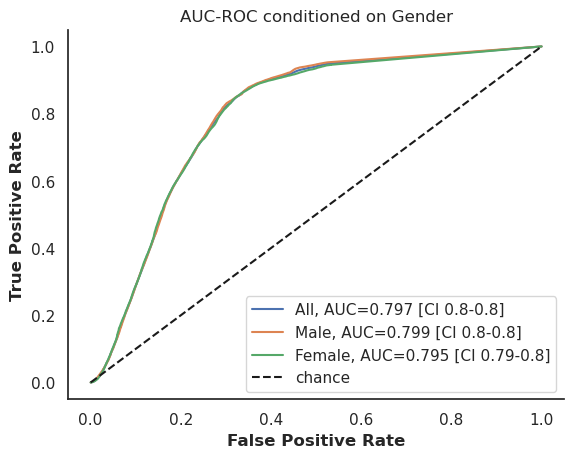

In [262]:
# ROC curves
# ALL
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][:,1],
    test_predictions[:,1]
)
general_auc = np.round(metrics.roc_auc_score(np_test[1][:, 1], test_predictions[:, 1], average='micro'), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1], test_predictions, metric='AUROC')
plt.plot(fpr, tpr, label="All, AUC={} [CI {}-{}]".format(str(general_auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# MALE
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.nsrr_sex == "male"][:,1],
    pretrained_model.predict(np_test[0][test_listfile.nsrr_sex == "male"])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.nsrr_sex == "male", 1], pretrained_model.predict(np_test[0][test_listfile.nsrr_sex == "male"])[:, 1], average='micro'), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.nsrr_sex == "male"], pretrained_model.predict(np_test[0][test_listfile.nsrr_sex == "male"]), metric='AUROC')
plt.plot(fpr, tpr, label="Male, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))
check_min_max(auc, "Male")

# FEMALE
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.nsrr_sex == "female"][:,1],
    pretrained_model.predict(np_test[0][test_listfile.nsrr_sex == "female"])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.nsrr_sex == "female", 1], pretrained_model.predict(np_test[0][test_listfile.nsrr_sex == "female"])[:, 1], average='micro'), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.nsrr_sex == "female"], pretrained_model.predict(np_test[0][test_listfile.nsrr_sex == "female"]), metric='AUROC')
plt.plot(fpr, tpr, label="Female, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))
check_min_max(auc, "Female")

plt.plot([0, 1], [0, 1], 'k--', label='chance')  # random predictions curve

#create ROC curve
plt.title('AUC-ROC conditioned on Gender')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(False)
sns.despine()
plt.legend(loc='lower right')
plt.savefig(os.path.join(image_folder, 'gender.pdf'), bbox_inches='tight')

In [263]:
# append row to log file arrays
append_row(general_auc, 'Gender')
reset_min_max()

## Performance conditioned on Ethnicity

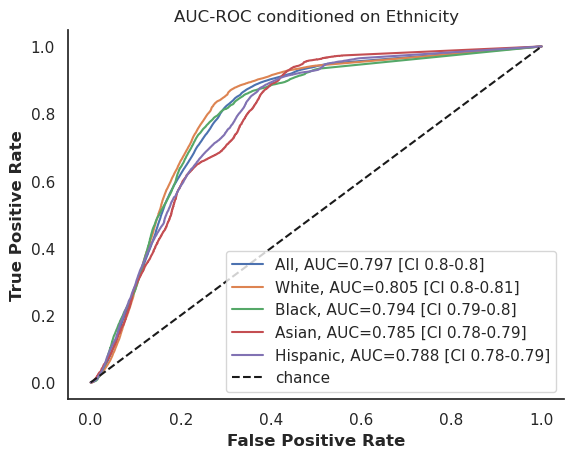

In [264]:
# test_listfile.nsrr_race.value_counts()[:10].index.tolist()
# test_listfile.nsrr_race.value_counts()
# ROC curves
# ALL
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][:,1],
    test_predictions[:,1]
)
general_auc = np.round(metrics.roc_auc_score(np_test[1][:, 1], test_predictions[:, 1], average='micro'), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1], test_predictions, metric='AUROC')
plt.plot(fpr, tpr, label="All, AUC={} [CI {}-{}]".format(str(general_auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# WHITE
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.nsrr_race.str.contains("white")][:,1],
    pretrained_model.predict(np_test[0][test_listfile.nsrr_race.str.contains("white")])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.nsrr_race.str.contains("white"), 1], pretrained_model.predict(np_test[0][test_listfile.nsrr_race.str.contains("white")])[:, 1], average='micro'), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.nsrr_race.str.contains("white")], pretrained_model.predict(np_test[0][test_listfile.nsrr_race.str.contains("white")]), metric='AUROC')
plt.plot(fpr, tpr, label="White, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))
check_min_max(auc, "white")

# BLACK
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.nsrr_race.str.contains("black or african american")][:,1],
    pretrained_model.predict(np_test[0][test_listfile.nsrr_race.str.contains("black or african american")])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.nsrr_race.str.contains("black or african american"), 1], pretrained_model.predict(np_test[0][test_listfile.nsrr_race.str.contains("black or african american")])[:, 1], average='micro'), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.nsrr_race.str.contains("black or african american")], pretrained_model.predict(np_test[0][test_listfile.nsrr_race.str.contains("black or african american")]), metric='AUROC')
plt.plot(fpr, tpr, label="Black, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))
check_min_max(auc, "black or african american")

# ASIAN
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.nsrr_race.str.contains("asian")][:,1],
    pretrained_model.predict(np_test[0][test_listfile.nsrr_race.str.contains("asian")])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.nsrr_race.str.contains("asian"), 1], pretrained_model.predict(np_test[0][test_listfile.nsrr_race.str.contains("asian")])[:, 1], average='micro'), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.nsrr_race.str.contains("asian")], pretrained_model.predict(np_test[0][test_listfile.nsrr_race.str.contains("asian")]), metric='AUROC')
plt.plot(fpr, tpr, label="Asian, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))
check_min_max(auc, "asian")

# HISPANIC/LATINO
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.nsrr_race.str.contains("hispanic")][:,1],
    pretrained_model.predict(np_test[0][test_listfile.nsrr_race.str.contains("hispanic")])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.nsrr_race.str.contains("hispanic"), 1], pretrained_model.predict(np_test[0][test_listfile.nsrr_race.str.contains("hispanic")])[:, 1], average='micro'), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.nsrr_race.str.contains("hispanic")], pretrained_model.predict(np_test[0][test_listfile.nsrr_race.str.contains("hispanic")]), metric='AUROC')
plt.plot(fpr, tpr, label="Hispanic, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))
check_min_max(auc, "hispanic")

plt.plot([0, 1], [0, 1], 'k--', label='chance')  # random predictions curve

#create ROC curve
plt.title('AUC-ROC conditioned on Ethnicity')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(False)
sns.despine()
plt.legend(loc='lower right')
plt.savefig(os.path.join(image_folder, 'ethnicity.pdf'), bbox_inches='tight')

In [265]:
# append row to log file arrays
append_row(general_auc, 'ETHNICITY')
reset_min_max()

## Performance conditioned on Age

In [266]:
subjects

,mesaid,examnumber,nsrr_age,nsrr_age_gt89,nsrr_sex,nsrr_race,nsrr_ahi_hp3u,nsrr_ahi_hp3r_aasm15,nsrr_ahi_hp4u_aasm15,nsrr_ahi_hp4r,nsrr_ttldursp_f1,nsrr_phrnumar_f1,nsrr_flag_spsw
0,1,5,70.0,no,female,white,18.14,27.56,9.94,23.02,344.0,27.03,full scoring
1,2,5,83.0,no,female,white,8.34,10.75,3.85,7.38,374.0,24.55,full scoring
2,6,5,57.0,no,female,hispanic,62.51,67.21,51.12,58.32,358.0,21.79,full scoring
3,10,5,57.0,no,male,white,40.91,48.00,32.18,45.27,110.0,46.91,full scoring
4,12,5,80.0,no,male,white,27.47,33.63,20.22,29.89,273.0,28.79,full scoring
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,6804,5,77.0,no,female,black or african american,34.02,35.77,25.23,28.37,478.0,18.20,full scoring
2233,6807,5,60.0,no,male,hispanic,48.24,49.60,43.42,46.58,398.0,30.75,full scoring
2234,6810,5,77.0,no,male,hispanic,25.84,30.44,15.58,21.95,339.0,20.35,full scoring
2235,6811,5,79.0,no,male,hispanic,34.24,45.33,29.18,43.53,368.0,58.04,full scoring


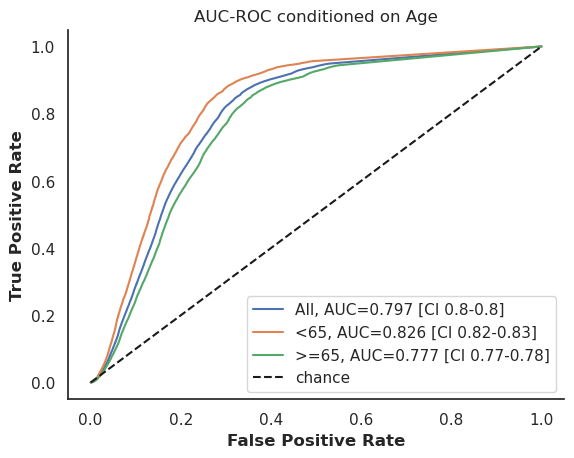

In [267]:
# ROC curves
# ALL
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][:,1],
    test_predictions[:,1]
)
general_auc = np.round(metrics.roc_auc_score(np_test[1][:, 1], test_predictions[:, 1], average='micro'), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1], test_predictions, metric='AUROC')
plt.plot(fpr, tpr, label="All, AUC={} [CI {}-{}]".format(str(general_auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))

# <65 (1)
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.nsrr_age_gt65 == "no"][:,1],
    pretrained_model.predict(np_test[0][test_listfile.nsrr_age_gt65 == "no"])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.nsrr_age_gt65 == "no", 1], pretrained_model.predict(np_test[0][test_listfile.nsrr_age_gt65 == "no"])[:, 1], average='micro'), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.nsrr_age_gt65 == "no"], pretrained_model.predict(np_test[0][test_listfile.nsrr_age_gt65 == "no"]), metric='AUROC')
plt.plot(fpr, tpr, label="<65, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))
check_min_max(auc, "<65")

# >=65 (0)
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.nsrr_age_gt65 == "yes"][:,1],
    pretrained_model.predict(np_test[0][test_listfile.nsrr_age_gt65 == "yes"])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.nsrr_age_gt65 == "yes", 1], pretrained_model.predict(np_test[0][test_listfile.nsrr_age_gt65 == "yes"])[:, 1], average='micro'), 3)
low_CI_binary, high_CI_binary = get_ci_auc(np_test[1][test_listfile.nsrr_age_gt65 == "yes"], pretrained_model.predict(np_test[0][test_listfile.nsrr_age_gt65 == "yes"]), metric='AUROC')
plt.plot(fpr, tpr, label=">=65, AUC={} [CI {}-{}]".format(str(auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))
check_min_max(auc, ">=65")

plt.plot([0, 1], [0, 1], 'k--', label='chance')  # random predictions curve

#create ROC curve
plt.title('AUC-ROC conditioned on Age')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(False)
sns.despine()
plt.legend(loc='lower right')
plt.savefig(os.path.join(image_folder, 'age.pdf'), bbox_inches='tight')

In [268]:
# append row to log file arrays
append_row(general_auc, 'AGE')
reset_min_max()

In [269]:
import tensorflow.keras.backend as K
trainable_count = np.sum([K.count_params(w) for w in pretrained_model.trainable_weights])

In [270]:
df_fairness_auc = pd.DataFrame({'metric': con_metrics, 'protected_attribute': con_protected_attributes, 'max_group': con_max_groups, 'max_value': con_max_values, 'max_delta': con_max_deltas, 'min_group': con_min_groups, 'min_value': con_min_values, 'min_delta': con_min_deltas, 'parameters': trainable_count, 'model_name': model_name, 'subfolder': subfolder, 'added_layers': added_layers, 'frozen_layers': frozen_layers, 'tag': tag})
print(df_fairness_auc.head())
df_fairness_auc.to_csv(os.path.join(working_directory, subfolder, model_name.replace('.hdf5', '_conditioned_metrics.csv')), index=False)

  metric protected_attribute max_group  max_value  max_delta min_group  \
0  AUROC              Gender      Male      0.799      0.002    Female   
1  AUROC           ETHNICITY     white      0.805      0.008     asian   
2  AUROC                 AGE       <65      0.826      0.029      >=65   

   min_value  min_delta  parameters                model_name  \
0      0.795     -0.002       45506  simclr.frozen.16.12.hdf5   
1      0.785     -0.012       45506  simclr.frozen.16.12.hdf5   
2      0.777     -0.020       45506  simclr.frozen.16.12.hdf5   

                                       subfolder  added_layers  frozen_layers  \
0  20231201-084504_e200_esTrue_bs128_wTrue_f2_fl             2              2   
1  20231201-084504_e200_esTrue_bs128_wTrue_f2_fl             2              2   
2  20231201-084504_e200_esTrue_bs128_wTrue_f2_fl             2              2   

         tag  
0  frozen2fl  
1  frozen2fl  
2  frozen2fl  


## AIF360
Quantifying biases in data and models
### Data Biases
In this section, we assess biases in the ground truth labels (NOT predicted labels) in training, validation and test data.
#### Train-Validation-Test Set Predictions: Bias Assessment

In [271]:
# dataframe that contains training, validation, and test data all together
df.rename({'wake':'y_true'}, axis=1, inplace=True)
df = df[['mesaid', 'y_true', 'nsrr_age_gt89', 'nsrr_age_gt65', 'nsrr_sex', 'nsrr_race']]
df.head()

,mesaid,y_true,nsrr_age_gt89,nsrr_age_gt65,nsrr_sex,nsrr_race
0,1010,0.0,no,yes,female,black or african american
1,1010,0.0,no,yes,female,black or african american
2,1010,0.0,no,yes,female,black or african american
3,1010,0.0,no,yes,female,black or african american
4,1010,0.0,no,yes,female,black or african american


In [272]:
protected_attributes = ['nsrr_age_gt89', 'nsrr_age_gt65', 'nsrr_sex', 'nsrr_race']
privileged_classes = [['no'], ['no'], ['male'], ['white']]

In [273]:
dataset = StandardDataset(df,
                          label_name='y_true',
                          favorable_classes=[1],  # not a favorable outcome, but perhaps the most important
                          protected_attribute_names=protected_attributes,
                          privileged_classes=privileged_classes)

bias_columns_metric = pd.DataFrame(columns=['protected_attribute', 'mean_difference', 'disparate_impact_ratio'])
for attr in dataset.protected_attribute_names:
    print("\nEvaluating Outcome Bias for {}".format(attr))
    idx = dataset.protected_attribute_names.index(attr)
    privileged_groups = [{attr: dataset.privileged_protected_attributes[idx][0]}]
    unprivileged_groups = [{attr: dataset.unprivileged_protected_attributes[idx][0]}]

    metric_data = BinaryLabelDatasetMetric(dataset, unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)
    bias_columns_metric.loc[len(bias_columns_metric.index)] = [attr, metric_data.mean_difference(), metric_data.disparate_impact()]
    print("Group Fairness - Mean Difference: {}".format(metric_data.mean_difference()))
    print("Group Fairness - Disparate Impact Ratio: {}".format(metric_data.disparate_impact()))
bias_columns_metric.head(10)


Evaluating Outcome Bias for nsrr_age_gt89
Group Fairness - Mean Difference: -0.037900382396479276
Group Fairness - Disparate Impact Ratio: 0.8462608205309113

Evaluating Outcome Bias for nsrr_age_gt65
Group Fairness - Mean Difference: -0.005234804647659436
Group Fairness - Disparate Impact Ratio: 0.9790143045696903

Evaluating Outcome Bias for nsrr_sex
Group Fairness - Mean Difference: -0.024141323280625238
Group Fairness - Disparate Impact Ratio: 0.9069059544888733

Evaluating Outcome Bias for nsrr_race
Group Fairness - Mean Difference: -0.004431907309136562
Group Fairness - Disparate Impact Ratio: 0.9821951383211017


,protected_attribute,mean_difference,disparate_impact_ratio
0,nsrr_age_gt89,-0.037900,0.846261
1,nsrr_age_gt65,-0.005235,0.979014
2,nsrr_sex,-0.024141,0.906906
3,nsrr_race,-0.004432,0.982195


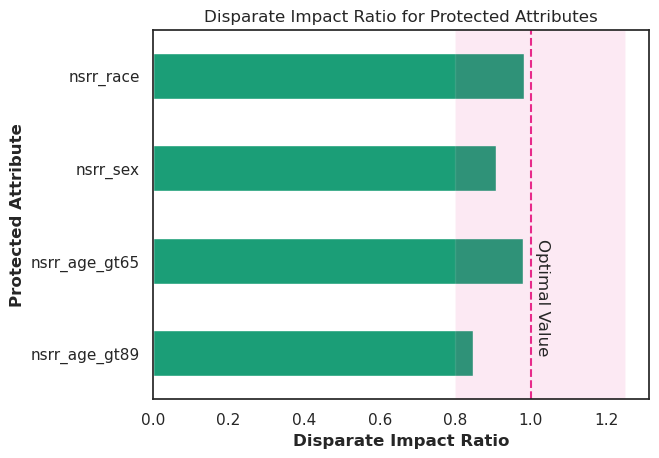

In [274]:
# plt.rcParams.update({'font.size': 15})
# plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
ax = bias_columns_metric[['protected_attribute', 'disparate_impact_ratio']].plot(kind='barh', colormap='Dark2')
ax.set_ylabel('Protected Attribute')
ax.set_xlabel('Disparate Impact Ratio')
ax.get_legend().remove()
ax.set_yticklabels(bias_columns_metric['protected_attribute'])

plt.axvline(x=1.0, color='#e72a8a', linestyle='--')
plt.axvspan(0.8, 1.25, facecolor='#e72a8a', alpha=0.1)
plt.text(1.01,0,'Optimal Value', rotation=270)
plt.title("Disparate Impact Ratio for Protected Attributes")
plt.savefig(os.path.join(image_folder, 'representationDIR.pdf'), format='pdf', bbox_inches="tight")
plt.savefig(os.path.join(image_folder, 'representationDIR.png'), bbox_inches="tight")
# plt.show()

**Note:** Disparate Impact Ratio (DIR) greater than 1 means that the privileged group has fewer positive mortality labels (fewer deaths) in the dataset compared to other groups. If DIR is greater than 1.25, then the dataset is considered biased/imbalanced, in a sense that some protected groups appear to have higher mortality than others. In some cased, e.g., AGE, that might be reasonable, while in others, e.g., LANGUAGE and INSURANCE type, it shouldn't be the case.
#### Test Set Predictions: Bias Assessment

In [275]:
test_listfile.rename({'wake':'y_true'}, axis=1, inplace=True)
test_listfile = test_listfile[['y_true', 'nsrr_age_gt89', 'nsrr_age_gt65', 'nsrr_sex', 'nsrr_race']]
test_listfile

,y_true,nsrr_age_gt89,nsrr_age_gt65,nsrr_sex,nsrr_race
0,0.0,no,yes,male,hispanic
1,0.0,no,yes,male,hispanic
2,1.0,no,yes,male,hispanic
3,0.0,no,yes,male,hispanic
4,0.0,no,yes,male,hispanic
...,...,...,...,...,...
452010,1.0,no,no,male,asian
452011,1.0,no,no,male,asian
452012,1.0,no,no,male,asian
452013,1.0,no,no,male,asian


In [276]:
dataset = StandardDataset(test_listfile,
                          label_name='y_true',
                          favorable_classes=[1],  # not a favorable outcome, but perhaps the most important
                          protected_attribute_names=protected_attributes,
                          privileged_classes=privileged_classes)

bias_columns_metric = pd.DataFrame(columns=['protected_attribute', 'mean_difference', 'disparate_impact_ratio'])
for attr in dataset.protected_attribute_names:
    print("\nEvaluating Outcome Bias for {}".format(attr))
    idx = dataset.protected_attribute_names.index(attr)
    privileged_groups = [{attr: dataset.privileged_protected_attributes[idx][0]}]
    unprivileged_groups = [{attr: dataset.unprivileged_protected_attributes[idx][0]}]

    metric_data = BinaryLabelDatasetMetric(dataset, unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)
    bias_columns_metric.loc[len(bias_columns_metric.index)] = [attr, metric_data.mean_difference(), metric_data.disparate_impact()]
    print("Group Fairness - Mean Difference: {}".format(metric_data.mean_difference()))
    print("Group Fairness - Disparate Impact Ratio: {}".format(metric_data.disparate_impact()))
bias_columns_metric.head(10)


Evaluating Outcome Bias for nsrr_age_gt89
Group Fairness - Mean Difference: -0.023256172885431886
Group Fairness - Disparate Impact Ratio: 0.9067352894429688

Evaluating Outcome Bias for nsrr_age_gt65
Group Fairness - Mean Difference: -0.010617275213815391
Group Fairness - Disparate Impact Ratio: 0.9584541915533854

Evaluating Outcome Bias for nsrr_sex
Group Fairness - Mean Difference: -0.03430926799689485
Group Fairness - Disparate Impact Ratio: 0.8710392246813519

Evaluating Outcome Bias for nsrr_race
Group Fairness - Mean Difference: -0.0031449301809686747
Group Fairness - Disparate Impact Ratio: 0.9874675243323124


,protected_attribute,mean_difference,disparate_impact_ratio
0,nsrr_age_gt89,-0.023256,0.906735
1,nsrr_age_gt65,-0.010617,0.958454
2,nsrr_sex,-0.034309,0.871039
3,nsrr_race,-0.003145,0.987468


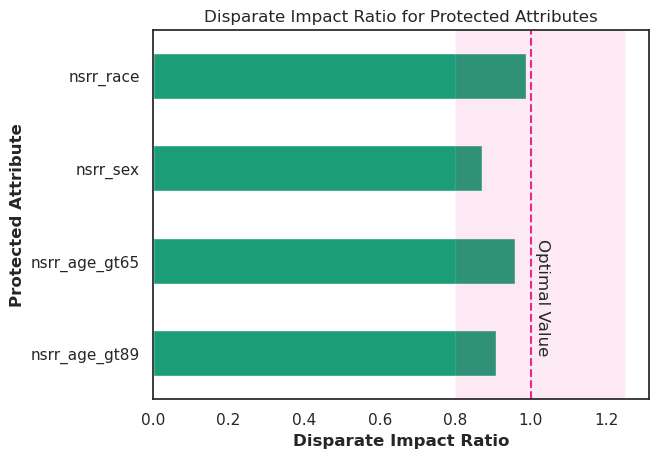

In [277]:
# plt.rcParams.update({'font.size': 15})
# plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
ax = bias_columns_metric[['protected_attribute', 'disparate_impact_ratio']].plot(kind='barh', colormap='Dark2')
ax.set_ylabel('Protected Attribute')
ax.set_xlabel('Disparate Impact Ratio')
ax.get_legend().remove()
ax.set_yticklabels(bias_columns_metric['protected_attribute'])

plt.axvline(x=1.0, color='#e72a8a', linestyle='--')
plt.axvspan(0.8, 1.25, facecolor='#e72a8a', alpha=0.1)
plt.text(1.01,0,'Optimal Value', rotation=270)
plt.title("Disparate Impact Ratio for Protected Attributes")
plt.savefig(os.path.join(image_folder, 'representationDIR.pdf'), format='pdf', bbox_inches="tight")
plt.savefig(os.path.join(image_folder, 'representationDIR.png'), bbox_inches="tight")
# plt.show()

### Model Biases
In this section, we assess biases in the predicted labels in the training, validation, and test data, or in the test data only.
**Interpretations:**
* Disparate Impact Ratio (Same with Statistical Parity Difference): How many users receive mortality predictions in the unprivileged group compared to the privileged group?
* False Positive Rate Ratio: From all the patients who did not eventually die, how many wrongfully received a mortality prediction?
* False Discovery Rate Ratio: TBA
* **False Negative Rate Ratio:** From all the patients who did die, how many had wrongfully received a non-mortality prediction?
* **False Omission Rate Ratio:** From all the patients who received a non-mortality prediction (rightfully or not), how many actually died?
* Error Rate Ratio: How many times was the mortality prediction model wrong?
* Equal Opportunity Difference: From all the patients who did eventually die, how many received a mortality prediction?
* Average Absolute Odds Difference: TBD

![image](metrictree.png)
#### Train-Validation-Test Set Predictions: Bias Assessment

In [278]:
# get predictions for df and test set
# Overall performance
train_predicted_labels = pd.Series(np.argmax(train_predictions, axis=1))
val_predicted_labels = pd.Series(np.argmax(validation_predictions, axis=1))
test_predicted_labels = pd.Series(np.argmax(test_predictions, axis=1))
df_predicted_labels = train_predicted_labels.append(val_predicted_labels).append(test_predicted_labels)
df_predicted_labels.reset_index(drop=True, inplace=True)
df.loc[:, 'y_pred'] = df_predicted_labels
df.head()

,mesaid,y_true,nsrr_age_gt89,nsrr_age_gt65,nsrr_sex,nsrr_race,y_pred
0,1010,0.0,no,yes,female,black or african american,0
1,1010,0.0,no,yes,female,black or african american,0
2,1010,0.0,no,yes,female,black or african american,0
3,1010,0.0,no,yes,female,black or african american,0
4,1010,0.0,no,yes,female,black or african american,0


In [279]:
# Dataset containing predictions
# for protected_attribute in protected_attributes:
#     print("\n------------- ATTRIBUTE: {} -------------\n".format(protected_attribute))
#     true_values, predictions = prepare_dataset_aif360(protected_attribute, df)
#     metric_pred, classified_metric = aif360_model(true_values, predictions, protected_attribute, privileged_classes[protected_attributes.index(protected_attribute)], favorable_class=1)
#     print_aif360_result(metric_pred, classified_metric)
#     # evaluating in terms of accuracy
#     print_aif360_accuracy_metrics(classified_metric)

#### Test Set Predictions: Bias Assessment

In [280]:
test_listfile.loc[:, 'y_pred'] = test_predicted_labels
test_listfile

,y_true,nsrr_age_gt89,nsrr_age_gt65,nsrr_sex,nsrr_race,y_pred
0,0.0,no,yes,male,hispanic,0
1,0.0,no,yes,male,hispanic,0
2,1.0,no,yes,male,hispanic,0
3,0.0,no,yes,male,hispanic,0
4,0.0,no,yes,male,hispanic,0
...,...,...,...,...,...,...
452010,1.0,no,no,male,asian,0
452011,1.0,no,no,male,asian,0
452012,1.0,no,no,male,asian,0
452013,1.0,no,no,male,asian,0


In [281]:
# Dataset containing predictions
df_protected = []
df_metric = []
df_value = []

for protected_attribute in protected_attributes:
    print("\n------------- ATTRIBUTE: {} -------------\n".format(protected_attribute))
    true_values, predictions = prepare_dataset_aif360(protected_attribute, test_listfile)
    metric_pred, classified_metric = aif360_model(true_values, predictions, protected_attribute, privileged_classes[protected_attributes.index(protected_attribute)], favorable_class=1)
    fairness_metrics = print_aif360_result(metric_pred, classified_metric)
    df_protected = df_protected + [protected_attribute for x in range(len(fairness_metrics))]
    df_metric = df_metric + list(fairness_metrics.keys())
    df_value = df_value + list(fairness_metrics.values())
    # evaluating in terms of accuracy
    print_aif360_accuracy_metrics(classified_metric)
df_fairness_metrics = pd.DataFrame({'protected_attribute': df_protected, 'fairness_metric': df_metric, 'value': df_value, 'parameters': trainable_count, 'model_name': model_name, 'subfolder': subfolder, 'added_layers': added_layers, 'frozen_layers': frozen_layers, 'tag': tag})


------------- ATTRIBUTE: nsrr_age_gt89 -------------

statistical_parity_difference: -0.3347285341820354
disparate_impact: 0.37004665040635115
equal_opportunity_difference: -0.061821205434732934
average_absolute_odds_difference: 0.24511873377000026
error_rate_difference: -0.32152909028914645
error_rate_ratio: 0.5337269424437923
false_discovery_rate_ratio: 0.9417082199692836
false_negative_rate_ratio: 1.075645166673724
false_omission_rate_ratio: 0.5689527709518679
false_positive_rate_ratio: 0.33800404826751784
true_positive_rate_difference: -0.061821205434732934
Privileged Group: {'TP': 20363.0, 'FP': 217077.0, 'TN': 118354.0, 'FN': 91064.0}
Unprivileged Group: {'TP': 141.0, 'FP': 873.0, 'TN': 3118.0, 'FN': 1025.0}

Overall Accuracy: 0.3140957711580368
Privileged Group: 0.3104274736045903
Unprivileged Group: 0.6319565638937367

Overall Error Rate: 0.6859042288419632
Privileged Group: 0.6895725263954098
Unprivileged Group: 0.36804343610626333

------------- ATTRIBUTE: nsrr_age_gt65 ----

In [282]:
df_fairness_metrics

,protected_attribute,fairness_metric,value,parameters,model_name,subfolder,added_layers,frozen_layers,tag
0,nsrr_age_gt89,statistical_parity_difference,-0.334729,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl
1,nsrr_age_gt89,disparate_impact,0.370047,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl
2,nsrr_age_gt89,equal_opportunity_difference,-0.061821,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl
3,nsrr_age_gt89,average_absolute_odds_difference,0.245119,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl
4,nsrr_age_gt89,error_rate_difference,-0.321529,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl
5,nsrr_age_gt89,error_rate_ratio,0.533727,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl
6,nsrr_age_gt89,false_discovery_rate_ratio,0.941708,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl
7,nsrr_age_gt89,false_negative_rate_ratio,1.075645,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl
8,nsrr_age_gt89,false_omission_rate_ratio,0.568953,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl
9,nsrr_age_gt89,false_positive_rate_ratio,0.338004,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl


In [283]:
df_fairness_metrics.to_csv(os.path.join(working_directory, subfolder, model_name.replace('.hdf5', '_fairness_metrics.csv')), index=False)
df_fairness_metrics.head()

,protected_attribute,fairness_metric,value,parameters,model_name,subfolder,added_layers,frozen_layers,tag
0,nsrr_age_gt89,statistical_parity_difference,-0.334729,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl
1,nsrr_age_gt89,disparate_impact,0.370047,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl
2,nsrr_age_gt89,equal_opportunity_difference,-0.061821,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl
3,nsrr_age_gt89,average_absolute_odds_difference,0.245119,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl
4,nsrr_age_gt89,error_rate_difference,-0.321529,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2,frozen2fl
